In [1]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00


In [ ]:
# Script to move images from root to fairface_sample folder

import os

import shutil

# Create folder if it doesn't exist
os.makedirs("fairface_sample", exist_ok=True)

# Move all uploaded images into that folder
image_extensions = ('.jpg', '.jpeg', '.png')
for file in os.listdir():
    if file.lower().endswith(image_extensions) and "fairface_sample" not in file:
        shutil.move(file, f"fairface_sample/{file}")

print("Face images moved into fairface_sample/")

Face images moved into fairface_sample/


In [14]:
import os
import pandas as pd
from deepface import DeepFace
import itertools

# List files from folder
folder = "fairface_sample"
images = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Parse demographic info
def parse_meta(filename):
    parts = filename.replace(".jpg" or "jpeg", "").replace(".png", "").split("_")
    if len(parts) >= 3:
        return {
            "file": filename,
            "race": parts[0],
            "gender": parts[1]
        }
    else:
        return None

meta = [parse_meta(f) for f in images]
meta = [m for m in meta if m is not None]  # Remove any malformed

print(f"Parsed {len(meta)} labeled face images")

Parsed 30 labeled face images


In [15]:
# Run DeepFace on every pair
results = []
for img1, img2 in itertools.combinations(meta, 2):
    try:
        result = DeepFace.verify(
            os.path.join(folder, img1["file"]),
            os.path.join(folder, img2["file"]),
            enforce_detection=False,
            model_name="VGG-Face"
        )

        results.append({
            "img1": img1["file"],
            "img2": img2["file"],
            "race1": img1["race"],
            "gender1": img1["gender"],
            "race2": img2["race"],
            "gender2": img2["gender"],
            "verified": result["verified"],
            "distance": result["distance"]
        })
    except Exception as e:
        print(f"Error comparing {img1['file']} and {img2['file']}: {e}")

print(f"Finished comparing {len(results)} pairs")

Finished comparing 435 pairs


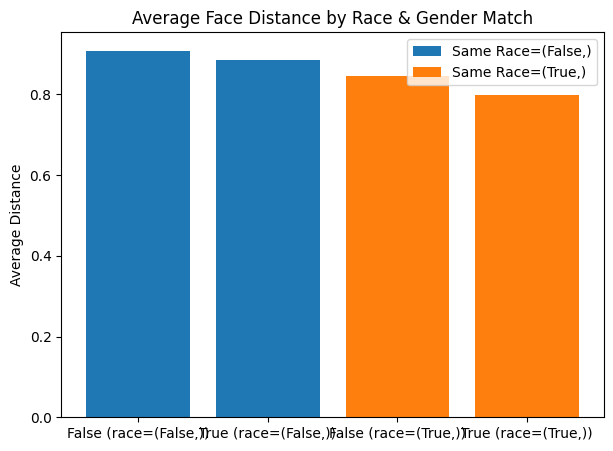

In [16]:
df = pd.DataFrame(results)

# Add comparison columns
df["same_race"] = df["race1"] == df["race2"]
df["same_gender"] = df["gender1"] == df["gender2"]

# Group and summary
summary = df.groupby(["same_race", "same_gender"]).agg(
    avg_distance=("distance", "mean"),
    match_rate=("verified", "mean"),
    comparisons=("verified", "count")
).reset_index()

summary
plt.figure(figsize=(7,5))
for key, grp in summary.groupby(["same_race"]):
    plt.bar(
        grp["same_gender"].astype(str) + f" (race={key})",
        grp["avg_distance"],
        label=f"Same Race={key}"
    )

plt.ylabel("Average Distance")
plt.title("Average Face Distance by Race & Gender Match")
plt.legend()
plt.show()

In [ ]:
original = "fairface_sample/white_male_1.jpg"

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

img_path = original
img = cv2.imread(img_path)

# 1. Blurred image
blur = cv2.GaussianBlur(img, (15, 15), 0)

# 2. Occluded image (black rectangle over eyes)
occlusion = img.copy()
cv2.rectangle(occlusion, (40, 60), (120, 90), (0, 0, 0), -1)

# 3. Rotated image
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle=15, scale=1.0)
rotated = cv2.warpAffine(img, M, (w, h))

# Save variants
cv2.imwrite("blur.jpg", blur)
cv2.imwrite("occlusion.jpg", occlusion)
cv2.imwrite("rotated.jpg", rotated)

print("Image variants saved.")

Image variants saved.


         Variant  Verified  Distance
0       blur.jpg      True    0.1166
1  occlusion.jpg      True    0.0218
2    rotated.jpg      True    0.0430


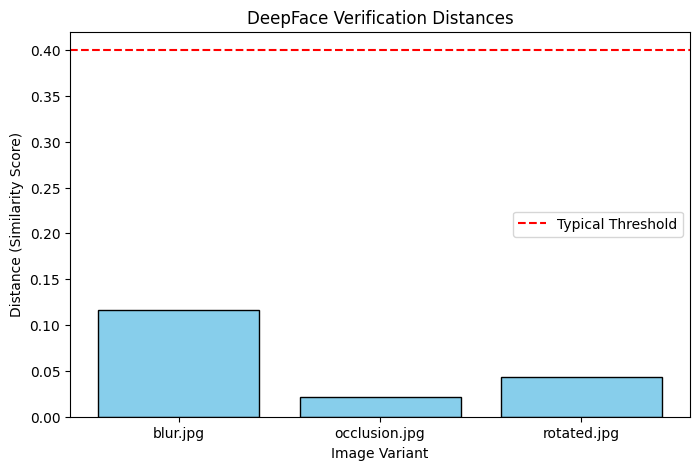

In [18]:
from deepface import DeepFace
import matplotlib.pyplot as plt


variants = ["blur.jpg", "occlusion.jpg", "rotated.jpg"]

results = []

for variant in variants:
    result = DeepFace.verify(img_path, variant, enforce_detection=False)
    results.append({
        "Variant": variant,
        "Verified": result['verified'],
        "Distance": round(result['distance'], 4)
    })

df = pd.DataFrame(results)

print(df)

plt.figure(figsize=(8,5))
plt.bar(df["Variant"], df["Distance"], color="skyblue", edgecolor="black")
plt.axhline(y=0.4, color="red", linestyle="--", label="Typical Threshold")
plt.xlabel("Image Variant")
plt.ylabel("Distance (Similarity Score)")
plt.title("DeepFace Verification Distances")
plt.legend()
plt.show()
